In [1]:
import uproot as ut
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
from uproot3_methods import TLorentzVectorArray
import vector
import awkward as ak
import itertools
from lmfit import Model
from tqdm import tqdm

import numpy as np

filename = "../analyzer/NMSSM_XYH_YToHH_6b_MX_700_MY_400_reco_preselections.root:sixBtree"
ttree = ut.open(filename)

In [2]:
class Particle:
    def p4(self): 
        return vector.obj(pt=self.pt, 
                          eta=self.eta, 
                          phi=self.phi, 
                          mass=self.m)

class BJet(Particle):
    def __init__(self,ttree,tag,id):
        self.id = id
        self.tag = tag
        self.pt = ttree[f"{tag}_recojet_ptRegressed"].array()
        self.eta = ttree[f"{tag}_recojet_eta"].array()
        self.phi = ttree[f"{tag}_recojet_phi"].array()
        self.m = ttree[f"{tag}_recojet_m"].array()
    def __str__(self): return self.tag
        
class Mother(Particle):
    def __init__(self,p_1,p_2):
        p4 = p_1.p4() + p_2.p4()
        self.pt = p4.pt
        self.eta = p4.eta
        self.phi = p4.phi
        self.m = p4.mass

In [3]:
bjetlist = []
for higgs in ("HX","HY1","HY2"):
    for bi in ("b1","b2"):
        bjetlist.append( BJet(ttree,f"{higgs}_{bi}",len(bjetlist)) )
        
HX = Mother(bjetlist[0],bjetlist[1])
HY1 = Mother(bjetlist[2],bjetlist[3])
HY2 = Mother(bjetlist[4],bjetlist[5])

Y = Mother(HY1,HY2)
X = Mother(Y,HX)

In [4]:
def gaussian(x, mu, sigma):
    """1-d gaussian: gaussian(x, mu, sigma)"""
    return (1 / (np.sqrt(2*np.pi) * sigma)) * np.exp(-(x-mu)**2 / (2*sigma**2))

def mass_dist(p,mass,plot=False):
    bins = np.linspace(mass*(1-0.6),mass*(1+0.6),100)
    bin_width = bins[1]-bins[0]
    xdata = [ edge + bin_width/2 for edge in bins[:-1] ]
    ydata, _ = np.histogram(np.array(p.m),bins=bins,density=1)
    
    gmodel = Model(gaussian)
    result = gmodel.fit(ydata,x=xdata,mu=mass,sigma=10)

    if plot:
        plt.hist(p.m,bins=bins,density=1)
        plt.plot(xdata,ydata,'k--')
        plt.plot(xdata,result.best_fit,'r-')
        plt.title("mu: {mu:0.4f} - sigma: {sigma:0.4f}".format(**result.best_values))
        plt.show()
    return result

In [5]:
X_fit = mass_dist(X,700)
Y_fit = mass_dist(Y,400)
HX_fit = mass_dist(HX,125)
HY1_fit = mass_dist(HY1,125)
HY2_fit = mass_dist(HY2,125)

In [6]:
higgs_pairs = [(0,1),(2,3),(4,5)]

def generate_groups(lst, n, depth=0):
    if not lst:
        yield []
    else:
        for group in (((lst[0],) + xs) for xs in itertools.combinations(lst[1:], n-1)):
            for groups in generate_groups([x for x in lst if x not in group], n,depth=depth+1):
                yield [group] + groups
bjet_comb = list(generate_groups( range(6) ,2))

event_configs = {0:[],1:[],2:[],3:[]}

for comb in bjet_comb:
    nH = sum( pair in higgs_pairs for pair in comb )
    for ip in range(3):
        config = []
        for jp in range(3):
            for b in comb[(ip+jp)%3]:
                config.append( bjetlist[b] )
        event_configs[nH].append(config)

In [7]:
def calc_config_chi2(bjet_config):
    HX = Mother(bjet_config[0],bjet_config[1])
    HY1 = Mother(bjet_config[2],bjet_config[3])
    HY2 = Mother(bjet_config[4],bjet_config[5])
    Y = Mother(HY1,HY2)
    X = Mother(Y,HX)
    
    chi2_list =[( (HX.m - HX_fit.best_values['mu'])/HX_fit.best_values['sigma'] )**2 ,
                ( (HY1.m - HY1_fit.best_values['mu'])/HY1_fit.best_values['sigma'] )**2, 
                ( (HY2.m - HY2_fit.best_values['mu'])/HY2_fit.best_values['sigma'] )**2 ,
                ( (Y.m - Y_fit.best_values['mu'])/Y_fit.best_values['sigma'] )**2 ,
                ( (X.m - X_fit.best_values['mu'])/X_fit.best_values['sigma'] )**2 ]
    return sum(chi2_list[:2]),sum(chi2_list)

In [8]:
full_config_chi2, higgs_config_chi2 = {},{}

for nh,configs in event_configs.items():
    full_config_chi2[nh] = []
    higgs_config_chi2[nh] = []
    for config in tqdm(configs):
        full_chi2,higgs_chi2 = calc_config_chi2(config)
        full_config_chi2[nh].append( full_chi2 )
        higgs_config_chi2[nh].append( higgs_chi2 )

100%|██████████| 18/18 [00:07<00:00,  2.57it/s]
0it [00:00, ?it/s]
100%|██████████| 3/3 [00:01<00:00,  2.42it/s]


In [9]:
def plot_chi2(ax,tru_config,fake_configs,title,bins=np.linspace(0,50,100)):
    ax.set_title(title)
    ax.set_ylabel("Events")
    ax.set_xlabel("Chi^2")
    ax.hist(tru_config,color='black',bins=bins,label="Real Config")
    nfake = len(fake_configs)
    for i,fake_config in enumerate(fake_configs):
        ax.hist(fake_config,histtype='step',color='red',bins=bins,label=f"{title} ({nfake})" if i == 0 else None)
    ax.legend()

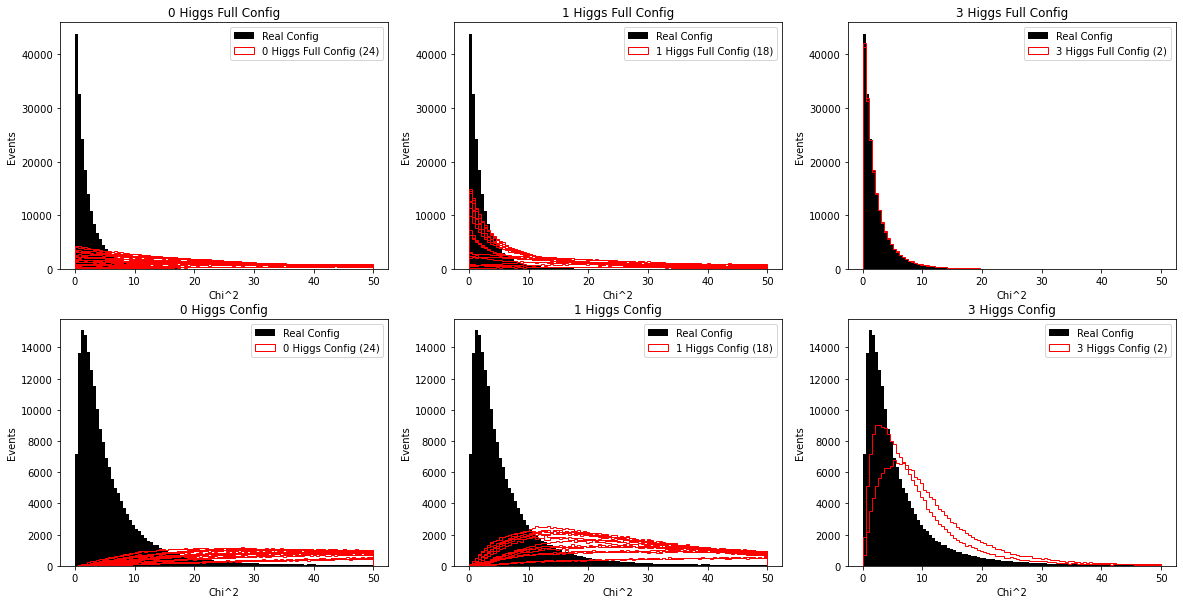

In [10]:
fig, axs = plt.subplots( nrows=2, ncols=3, figsize=(20,10))

real_full_config = full_config_chi2[3][0]

plot_chi2(axs[0,0],real_full_config,full_config_chi2[0],"0 Higgs Full Config")
plot_chi2(axs[0,1],real_full_config,full_config_chi2[1],"1 Higgs Full Config")
plot_chi2(axs[0,2],real_full_config,full_config_chi2[3][1:],"3 Higgs Full Config")

real_higgs_config = higgs_config_chi2[3][0]

plot_chi2(axs[1,0],real_higgs_config,higgs_config_chi2[0],"0 Higgs Config")
plot_chi2(axs[1,1],real_higgs_config,higgs_config_chi2[1],"1 Higgs Config")
plot_chi2(axs[1,2],real_higgs_config,higgs_config_chi2[3][1:],"3 Higgs Config")

In [11]:
full_nhiggs_chi2, higgs_nhiggs_chi2 = {},{}

for i in tqdm(full_config_chi2):
    full_nhiggs_chi2[i] = np.array(full_config_chi2[i]).flatten()
    higgs_nhiggs_chi2[i] = np.array(higgs_config_chi2[i]).flatten()

100%|██████████| 4/4 [00:42<00:00, 10.54s/it]


In [12]:
def plot_nhiggs_chi2(ax,tru_config,fake_config,title,bins=np.linspace(0,50,100),cut=None):
    ax.hist(tru_config,color='black',bins=bins,label="Real Config")
    ax.hist(fake_config,histtype='step',color='red',bins=bins,label=f"{title}")
    
    if cut is not None:
        nreal = ( np.array(tru_config) < cut ).sum()
        nfake = ( np.array(fake_config) < cut ).sum()
        title += f" - Eff(<{cut}): {nreal/(nreal+nfake):0.4f}"
    
    ax.set_title(title)
    ax.set_ylabel("Events")
    ax.set_xlabel("Chi^2")
    
    ax.legend()

<ipython-input-12-b7e3a3423c37>:7: RuntimeWarning: invalid value encountered in less
  nfake = ( np.array(fake_config) < cut ).sum()
<ipython-input-12-b7e3a3423c37>:7: RuntimeWarning: invalid value encountered in less
  nfake = ( np.array(fake_config) < cut ).sum()
<ipython-input-12-b7e3a3423c37>:7: RuntimeWarning: invalid value encountered in less
  nfake = ( np.array(fake_config) < cut ).sum()
<ipython-input-12-b7e3a3423c37>:7: RuntimeWarning: invalid value encountered in less
  nfake = ( np.array(fake_config) < cut ).sum()
<ipython-input-12-b7e3a3423c37>:7: RuntimeWarning: invalid value encountered in less
  nfake = ( np.array(fake_config) < cut ).sum()
<ipython-input-12-b7e3a3423c37>:7: RuntimeWarning: invalid value encountered in less
  nfake = ( np.array(fake_config) < cut ).sum()


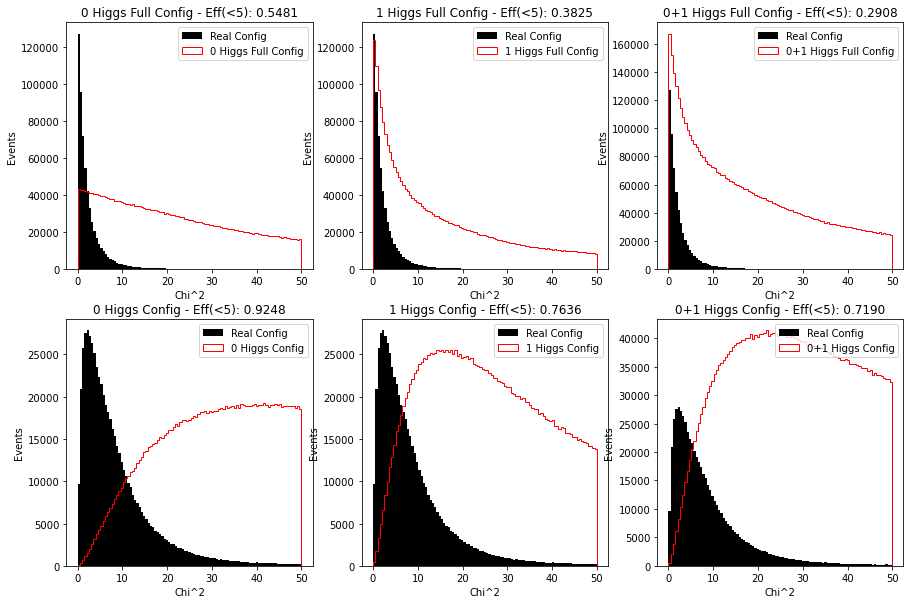

In [13]:
fig, axs = plt.subplots( nrows=2, ncols=3, figsize=(15,10))

real_full_nhiggs = full_nhiggs_chi2[3]
cut = 5

plot_nhiggs_chi2(axs[0,0],real_full_nhiggs,full_nhiggs_chi2[0],"0 Higgs Full Config",cut=cut)
plot_nhiggs_chi2(axs[0,1],real_full_nhiggs,full_nhiggs_chi2[1],"1 Higgs Full Config",cut=cut)
plot_nhiggs_chi2(axs[0,2],real_full_nhiggs, np.append(full_nhiggs_chi2[0],full_nhiggs_chi2[1]) ,"0+1 Higgs Full Config",cut=cut)

real_higgs_nhiggs = higgs_nhiggs_chi2[3]

plot_nhiggs_chi2(axs[1,0],real_higgs_nhiggs,higgs_nhiggs_chi2[0],"0 Higgs Config",cut=cut)
plot_nhiggs_chi2(axs[1,1],real_higgs_nhiggs,higgs_nhiggs_chi2[1],"1 Higgs Config",cut=cut)
plot_nhiggs_chi2(axs[1,2],real_higgs_nhiggs, np.append(higgs_nhiggs_chi2[0],higgs_nhiggs_chi2[1]),"0+1 Higgs Config",cut=cut)